In [1]:
# 先不取平均 看一看能否说明问题
import numpy as np
import sys
import os
sys.path.append(r'C:\Users\81004\1_jupyter_code\1_Functions')
import matplotlib.pyplot as plt
from cal_ppp_dis import cal_ppp_distance as cal_dis

In [3]:
# 读取xyz数据
root = r'D:\MD_file\Corning\march\laso4\results'
file_path = os.path.join(root,'cry_1000p_out.lmp')

save_path = os.path.join(root,r'data\out_data.xyz')
start_frame = 0
end_frame = 200
step_frame = 1
###########

# 要分析的元素
ana_element = ['Si','O','Al']
# lmp对应的值
dic_charge = {2.4:'Si', -1.2:'O', 1.8:'Al', 0.6:'Li'}
# 画出分布的元素
draw_element = ['O']
set_cutoff = 4.0

In [5]:
dic_charge[2.4]

'Si'

In [7]:
# 先按照要求读取所有的lmp数据
# 每一个原子的信息
class Atom:
    def __init__(self, id0, type0, q, x, y, z, vx, vy, vz, fx, fy, fz, c_ke_atom, c_pe_atom, v_e_total):
        self.id = id0
        self.type = type0
        self.x = x
        self.y = y
        self.z = z
        self.q = q
        self.vx = vx
        self.vy = vy
        self.vz = vz
        self.fx = fx
        self.fy = fy
        self.fz = fz
        self.c_ke_atom = c_ke_atom
        self.c_pe_atom = c_pe_atom
        self.v_e_total = v_e_total
    def print_info(self):
        print(f'id:{int(self.id)}, type:{self.type}, x:{self.x}, y:{self.y}, z:{self.z}, q:{self.q}')
        print(f'vx:{self.vx}, vy:{self.vy}, vz:{self.vz}, fx:{self.fx}, fy:{self.fy}, fz:{self.fz}')
        print(f'E_total:{self.v_e_total}, E_kinetic:{self.c_ke_atom}, E_potential:{self.c_pe_atom}')

In [9]:
def read_lmp(file_path):
    # 所有信息储存的总列表
    list_all_frames = []
    x_min,x_max,y_min,y_max,z_min,z_max = None,None,None, None,None,None
    box_size = [None, None, None]
    num_atom = None
    len_per_frame = None
    # 第一次打开,是看一下基本数据：
    with open(file_path,'r') as f_open:
        # 前三行都不要
        for i in range(3): 
            f_open.readline()
        # 第四行是Number
        num_atom = int(f_open.readline())
        # 定义一页的行数
        len_per_frame = num_atom + 9  
        # 第五行不要
        f_open.readline()
        # 存储range范围
        temp_range_list = []
        for i in range(3): 
            temp_min,temp_max,temp = f_open.readline().split()
            temp_range_list.append(temp_min)
            temp_range_list.append(temp_max)
        # 将字符串转换为浮点数并直接赋值给变量
        x_min, x_max, y_min, y_max, z_min, z_max = [float(i) for i in temp_range_list]
    print(f'Num of atom: {num_atom}')
    print(f'X range: {x_min}  {x_max}')
    print(f'Y range: {y_min}  {y_max}')
    print(f'Z range: {z_min}  {z_max}\n')
    
    # 开始读取文件
    f_open = open(file_path,'r')
    # 记录当前行数
    count_row = 0
    for i_frame in range(start_frame, end_frame, step_frame):
        if i_frame%50==0:
            print(f'Now is reading frame {i_frame}')
        list_frame = []
        # 先判断下是不是我要的这页
        now_frame_count = len_per_frame*i_frame
        # 如果不是同一页，则跳过这一页,再继续空读
        while count_row!=now_frame_count:
            # print(f'Now:{now_frame_count}  count:{count_row}')
            count_row+=len_per_frame
            for i in range(len_per_frame):
                f_open.readline()
        # 如果是同一页，那么就开始读取数据
        else:
            # print(f'Now:{now_frame_count}  count:{count_row}')
            # 首先就是跳过表头的9行
            # for i in range(9):
            #     f_open.readline()
            # 读取表头九行的数据
            f_open.readline()
            time_step = int(f_open.readline())
            f_open.readline()
            atom_num = float(f_open.readline())
            f_open.readline()
            x_low,x_high,temp = f_open.readline().split()
            y_low,y_high,temp = f_open.readline().split()
            z_low,z_high,temp = f_open.readline().split()
            f_open.readline()
            x_low,x_high,y_low,y_high,z_low,z_high = float(x_low),float(x_high),float(y_low),float(y_high),float(z_low),float(z_high)
            dic_system = {'timestep':time_step, 
                         'num_atoms':atom_num,
                          'x_low':x_low,'x_high':x_high,
                          'y_low':y_low,'y_high':y_high,
                          'z_low':z_low,'z_high':z_high,
                         }
            # 再读取其余的数据
            for j_row in range(num_atom):
                temp_data = f_open.readline().split()
                id0, type0, q, x, y, z, vx, vy, vz, fx, fy, fz, c_ke_atom, c_pe_atom, v_e_total = [float(i) for i in temp_data]
                #print(id0, type0, q, x, y, z)
                # 类型转换回 str
                type0 = dic_charge[q]
                temp_atom = Atom(id0, type0, q, x, y, z, vx, vy, vz, fx, fy, fz, c_ke_atom, c_pe_atom, v_e_total)
                list_frame.append(temp_atom)
            # 这一页读取完了,首先是对原子的id排序
            list_frame = sorted(list_frame, key = lambda Atom:Atom.id)
            # 再存入信息帧中
            frame_data = {
                "atom_data":list_frame,
                'system_info':dic_system
            }
            list_all_frames.append(frame_data)
            count_row+=len_per_frame
         
    # 关闭文件
    print('文件读取完毕！')
    f_open.close()
    return list_all_frames
def read_xyz_frames(file_path):
    frames = []
    current_frame = None

    with open(file_path, 'r') as file:
        lines = file.readlines()
        line_index = 0

        while line_index < len(lines):
            line = lines[line_index].strip()

            if line.isdigit():
                # 读取原子数
                if current_frame:
                    frames.append(current_frame)
                num_atoms = int(line)
                current_frame = {"num_atoms": num_atoms, "atoms": []}
                line_index += 2  # 跳过标题行 "Atoms"
            else:
                # 读取原子坐标
                if current_frame:
                    atom_data = line.split()
                    if len(atom_data) == 4:
                        element, x, y, z = atom_data
                        current_frame["atoms"].append({
                            "element": element,
                            "x": float(x),
                            "y": float(y),
                            "z": float(z)
                        })
                line_index += 1

        if current_frame:
            frames.append(current_frame)
    print('文件读取完毕！')
    return frames

In [11]:
file_type = file_path.split('\\')[-1].split('.')[-1]
frames = None
if file_type=='lmp':
    print('输入文件为lmp格式！')
    frames = read_lmp(file_path)   
elif file_type=='xyz':
    frames = read_xyz_frames(file_path)
    # 找出最大的x、y和z值
    max_x = max([max(frame["atoms"], key=lambda atom: atom["x"])["x"] for frame in frames])
    max_y = max([max(frame["atoms"], key=lambda atom: atom["y"])["y"] for frame in frames])
    max_z = max([max(frame["atoms"], key=lambda atom: atom["z"])["z"] for frame in frames])
    print("Maximum X value:", max_x)
    print("Maximum Y value:", max_y)
    print("Maximum Z value:", max_z)
else:
    print('输入文件有误！')

输入文件为lmp格式！
Num of atom: 6097
X range: 0.0  119.289594
Y range: 0.0  59.644797
Z range: 0.0  11.332511

Now is reading frame 0


ValueError: not enough values to unpack (expected 15, got 12)

# 使用pyscal计算Q4-Q6

In [8]:
from pyscal3 import System
from pyscal3 import Atoms

In [9]:
def cal_bop(cal_list,ana_frame):
    frames = cal_list
    temp_system = frames[ana_frame]['system_info']
    temp_frame = frames[ana_frame]['atom_data']
    len_x,len_y,len_z = temp_system['x_high'],temp_system['y_high'],temp_system['z_high']
    sys = System()
    sys.box = [[len_x,0,0],[0,len_y,0],[0,0,len_z]]
    sys.box = [[117.413928, 0, 0], [0, 58.746064, 0], [0, 0, 11.158]]
    # 将list转为字典 取出我们要分析的元素 
    ana_atom_list = []
    atom_xyz = []
    for i_atom in temp_frame:
        if i_atom.type in ana_element: 
            atom_xyz.append([i_atom.x,i_atom.y,i_atom.z])
            ana_atom_list.append(i_atom)
    print(np.array(atom_xyz).shape)
    # 转换元素格式
    adict = {"positions": np.array(atom_xyz, dtype=object)}
    atoms = Atoms(adict)
    # print(atoms.species)
    # print(atoms.positions)
    # 实例化
    sys.atoms = atoms
    # 这是pyscal3的Adaptive cutoff methods
    sys.find.neighbors(method='cutoff', cutoff='adaptive', padding=1.5)
    coordination = [len(sys.atoms.neighbors.index[x]) for x in range(sys.natoms)]
    #################
    nos, counts = np.unique(coordination, return_counts=True)
    plt.bar(nos, counts, color="#AD1457")
    plt.ylabel("density")
    plt.xlabel("coordination number")
    plt.title("Cutoff adaptive method")
    # 计算q4和q6 然后采用均值的方法
    # q4_q6_list = sys.calculate.steinhardt_parameter([4,6], averaged=True)
    q4_q6_list = sys.calculate.steinhardt_parameter([4,6], averaged=True)
    print(f'Mean_q4:{sum(q4_q6_list[0])/len(q4_q6_list[0])}')
    return ana_atom_list, q4_q6_list,[len_x,len_y,len_z]

(5226, 3)
Mean_q4:0.14960715902236185


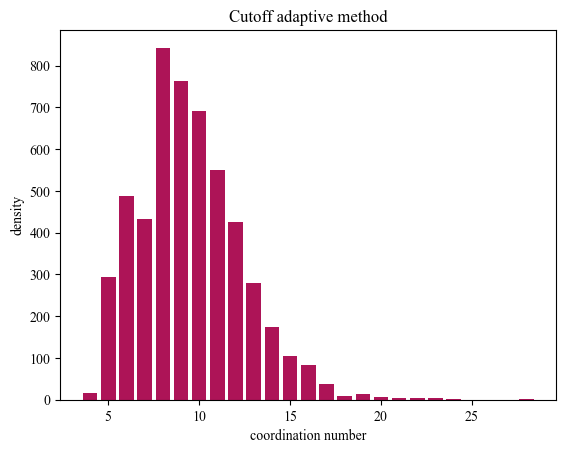

In [329]:
origin_ana_atom_list, origin_q4_q6_list,box_len = cal_bop(frames,100)

# bop数据处理

In [332]:
def select_ele(all_atom,draw_element,q4_q6_list):
    results_xyz_q4_q6 = []
    for i,i_atom in enumerate(all_atom):
        q4,q6 = q4_q6_list[0][i], q4_q6_list[1][i]
        if i_atom.type in draw_element:
            results_xyz_q4_q6.append([i_atom,q4,q6])
    print(results_xyz_q4_q6[0])
    return results_xyz_q4_q6

In [333]:
draw_element = ['O']
q4_q6_list = origin_q4_q6_list.copy()
ana_atom_list = origin_ana_atom_list.copy()
results_xyz_q4_q6 = select_ele(ana_atom_list,draw_element,q4_q6_list)

[<__main__.Atom object at 0x0000020F12B37620>, 0.14739676717881972, 0.09400733059064009]


In [334]:
results_xyz_q4_q6[0]

[<__main__.Atom at 0x20f12b37620>, 0.14739676717881972, 0.09400733059064009]

In [335]:
len(results_xyz_q4_q6)

3484

# 可视化分布

In [337]:
# 把结果筛选一遍 
new_res = results_xyz_q4_q6.copy()

In [338]:
new_res[-1][0].print_info()

id:3484, type:O, x:81.4272, y:35.1587, z:8.00057, q:-1.2
vx:-6.596, vy:-7.88346, vz:-1.21211, fx:-2.21311, fy:0.743568, fz:2.14718
E_total:-9.2247, E_kinetic:0.0888189, E_potential:-9.31352


In [339]:
print(len(new_res))

3484


In [341]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
    
def draw_q4(data_temp,critical_q4,label_list):
    # 从 data_list 中提取 x、y、q4 和 q6 数据
    #########
    x_data = [item[0].x for item in data_temp]
    y_data = [item[0].y for item in data_temp]
    q4_data = [item[1] for item in data_temp]
    q6_data = [item[2] for item in data_temp]
    
    # 创建二维分布图
    plt.figure(figsize=(10, 6) ,dpi=80)
    
    # 绘制 q4 在 x-y 平面上的二维分布图
    print('See Origin Figure')

    cry_point = [[],[]]
    mean_q4 = sum(q4_data)/len(q4_data)
    max_q4 = 0
    for i_x,i_y,i_q4, in zip(x_data,y_data,q4_data):
        if i_q4>critical_q4:
            max_q4+=1
            cry_point[0].append(i_x)
            cry_point[1].append(i_y)
    
    print('Mean q4:  ' + str(round(mean_q4,4))+'    Percentage of Q4 > 0.18: '+ str(round(max_q4/len(q4_data)*100,2))+'%')
    
    ###########################################
    # 定义viridis色谱的底端绿色渐变
    
    viridis_cmap = plt.get_cmap('viridis')
    
    # 生成顶端橙黄色的渐变，使用非常短的橙色段
    orange_yellow = ['#ffea00', '#ff7f0e']  # 橙色到黄色的 HEX 色码，顺序调整为黄色到橙色
    orange_yellow_cmap = LinearSegmentedColormap.from_list('orange_yellow', orange_yellow, N=8)
    
    # 合并两个色谱，创建自定义色谱
    colors = np.vstack((viridis_cmap(np.linspace(0, 1, 128)),
                        orange_yellow_cmap(np.linspace(0, 1, 8))))  # 使用非常短的橙色段
    custom_cmap = ListedColormap(colors)
    ###########################################################
    
    name_x = file_path.split('\\')[-1]
    # 绘制 q4 在 x-y 平面上的二维分布图
    # title_name = name_x+ '(' + str( ana_frame*10) + 'ns) '
    title_name = 'Atoms less than 15 Å from the crystal'
    plt.title(title_name , fontsize=15, fontweight='bold')  #+ str(ana_frame), fontsize=16, fontweight='bold')  # 设置标题字体大小和加粗
    
    ################
    plt.scatter(x_data, y_data, s=15, c=q4_data, cmap=custom_cmap, marker='o',vmin=0.05, vmax=critical_q4)
    plt.scatter(label_list[0],label_list[1],color='blue',label='atoms in glass')
    plt.colorbar()
    # plt.title('O' , fontsize=15, fontweight='bold')  #+ str(ana_frame), fontsize=16, fontweight='bold')  # 设置标题字体大小和加粗
    plt.xlabel('X-axis ', fontsize=15, fontweight='bold')  # 设置 x 轴标签字体大小和加粗
    plt.ylabel('Y-axis', fontsize=15, fontweight='bold')  # 设置 y 轴标签字体大小和加粗
    
    # 设置 x 轴刻度值的字体大小、颜色和加粗
    plt.xticks(range(0, int(max(x_data)) + 1, 10), fontsize=12, fontweight='bold')
    # 设置 y 轴刻度值的字体大小、颜色和加粗
    plt.yticks(fontsize=12, fontweight='bold')
    plt.legend()
    # 参考线
    # # 添加X参考线
    # plt.axvline(x=20, color='black', linestyle='-')  
    # plt.axvline(x=40, color='black', linestyle='-')  
    # plt.axvline(x=60, color='black', linestyle='-') 
    # plt.axvline(x=80, color='black', linestyle='-')
    # # 添加Y参考线
    # plt.axhline(y=20, color='black', linestyle='-') 
    # plt.axhline(y=40, color='black', linestyle='-') 
    # plt.axhline(y=60, color='black', linestyle='-') 
    # plt.axhline(y=80, color='black', linestyle='-') 
    # #plt.xticks(np.arange(0, 95, 20))
    #plt.yticks(np.arange(0, 95, 20))
    
    # 显示图形
    plt.show()

cry atom: 639
See Origin Figure
Mean q4:  0.1375    Percentage of Q4 > 0.18: 18.34%


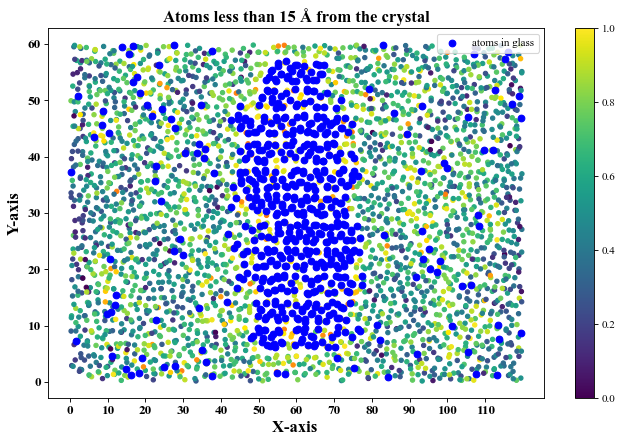

In [342]:
critical_q4 = 0.18
cry_point = [[],[]]
for i_item in new_res:
    i_atom,i_q4,i_q6 = i_item
    if i_q4>critical_q4:
        cry_point[0].append(i_atom.x)
        cry_point[1].append(i_atom.y)
print(f'cry atom: {len(cry_point[0])}')
draw_q4(new_res,critical_q4,cry_point)

# 数据清洗

In [344]:
# 判断条件 
# 1.如果一个点的四周q4值大于0.18的小于4 则设置为0.15
# 2.
boxsize = box_len

In [346]:
def cal_ppp_dis1(boxsize,point1,point2):
    i_1 = np.array([point1.x,point1.y,point1.z])
    j_1 = np.array([point2.x,point2.y,point2.z])
    boxsize = np.array(boxsize)
    # 计算
    delta = i_1-j_1
    delta = delta - np.round(delta / boxsize) * boxsize
    distance = np.linalg.norm(delta)
    return distance

In [348]:
# 遍历每一个原子
critical_dis = 5.0
critical_q4 = 0.18
critical_neibor_cry = 9
# 

def filter_bop(temp_list):
    filter_list = []
    for i_atom,i_q4,i_q6 in temp_list:
        # 如果原子不是q4>0.18
        if i_q4<critical_q4:
            filter_list.append([i_atom,i_q4,i_q6])
            continue
        #  如果大于0.18
        else:   
            count_cry = 0
            for j_atom,j_q4,j_q6 in temp_list:
                if cal_ppp_dis1(boxsize,i_atom,j_atom)<critical_dis and j_q4>critical_q4 :
                    count_cry+=1
            if count_cry<critical_neibor_cry:
                i_q4 = 0.15
            #elif count_cry>=critical_neibor_cry and i_q4<critical_q4:
                #i_q4 = critical_q4+0.01
            filter_list.append([i_atom,i_q4,i_q6])
    return  filter_list

cry atom: 508
See Origin Figure
Mean q4:  0.1358    Percentage of Q4 > 0.18: 14.58%


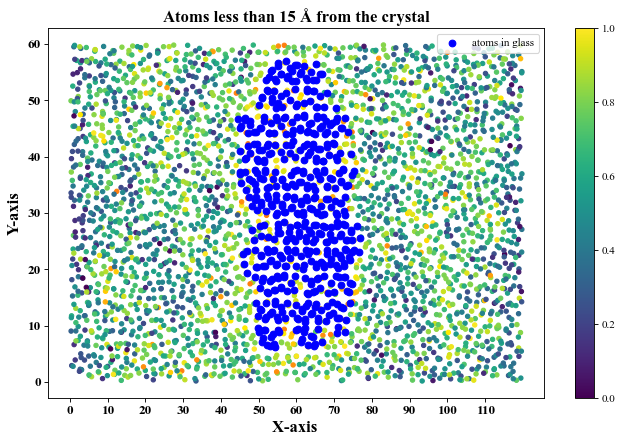

In [349]:
filter_list = filter_bop(new_res)
cry_point = [[],[]]
for i_item in filter_list:
    i_atom,i_q4,i_q6 = i_item
    if i_q4>critical_q4:
        cry_point[0].append(i_atom.x)
        cry_point[1].append(i_atom.y)
print(f'cry atom: {len(cry_point[0])}')
draw_q4(filter_list,0.18,cry_point)

# 然后计算出不同距离dis的原子

In [352]:
# 先按照要求读取所有的lmp数据
# 每一个原子的信息
class Label_atom(Atom):
    def __init__(self, atom, q4, label,mini_dis):
        self.atom = atom
        self.q4 = q4
        self.label = label
        self.mini_dis = mini_dis

In [353]:
filter_list[0]

[<__main__.Atom at 0x20f12b37620>, 0.14739676717881972, 0.09400733059064009]

In [354]:
# 先取出所有晶体原子
cry_list = []
for i_item in filter_list:
    i_atom,i_q4,i_q6 = i_item
    if i_q4>0.18:
        cry_list.append(i_item)
print(len(cry_list))

508


In [356]:
# 区分原子
# label 0 1 2 3
# dis  0  0-3.5 3.5-7
# 这是所有原子 然后给它标记距离
label_atoms_list = [[i,100,100] for i in ana_atom_list ]
# 这是晶体原子 
for i_item in cry_list:
    i_atom,i_q4,i_q6 = i_item
    for j_num in range(len(label_atoms_list)):
        # 先分类
        j_atom,j_q4,j_dis = label_atoms_list[j_num][0], label_atoms_list[j_num][1], label_atoms_list[j_num][2]
        # 先算距离 
        dis = cal_ppp_dis1(boxsize,i_atom,j_atom)
        if dis<j_dis:
            label_atoms_list[j_num][2] = dis

# 画出标记了的原子

In [359]:
label_atoms_list[58]

[<__main__.Atom at 0x20f1283b320>, 100, 40.54350864667878]

In [360]:
filter_list[0]

[<__main__.Atom at 0x20f12b37620>, 0.14739676717881972, 0.09400733059064009]

In [361]:
# 筛选在离晶体不远处的原子
def get_diff(label_atoms_list):
    dis_type = [4,14]
    diff_dis_atom = [[],[]]
    for i_item in label_atoms_list:
        i_atom = i_item[0]
        i_x,i_y = i_atom.x,i_atom.y
        if dis_type[0]<= i_item[2] <=dis_type[1]:
            diff_dis_atom[0].append(i_x)
            diff_dis_atom[1].append(i_y)
    return diff_dis_atom

See Origin Figure
Mean q4:  0.1358    Percentage of Q4 > 0.18: 14.58%


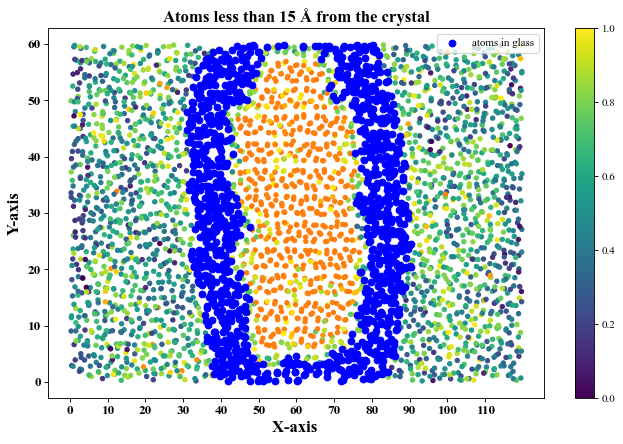

In [362]:
# 这是所有原子 然后给它标记距离 label_atoms_list

diff_dis_atom = get_diff(label_atoms_list)
draw_q4(filter_list, 0.18,diff_dis_atom)

In [363]:
label_atoms_list[0][0].print_info()

id:1, type:O, x:92.3027, y:30.345, z:0.874819, q:-1.2
vx:-12.6979, vy:-3.91414, vz:3.93765, fx:-1.20566, fy:-0.0216759, fz:-2.56979
E_total:-9.84553, E_kinetic:0.159241, E_potential:-10.0048


# 然后分析离晶体不远的近邻信息

In [365]:
# 然后分析性质随距离的变化
# id0, type0, q, x, y, z, vx, vy, vz, fx, fy, fz, c_ke_atom, c_pe_atom, v_e_total

In [366]:
np.linspace(0,5,3)

array([0. , 2.5, 5. ])

In [367]:
import math
# id0, type0, q, x, y, z, vx, vy, vz, fx, fy, fz, c_ke_atom, c_pe_atom, v_e_total
def ana_properties(ana_atom_list, delta,max_range):
    # 切分多少块儿
    count_num = math.ceil(max_range/delta)
    # 其实就是表示一下x的范围 
    data_range = np.arange(0,max_range,delta)
    # 记录数据 sum
    data_list = np.zeros_like(data_range)
    # 记录次数 count
    count_list = np.zeros_like(data_list)
    for i_item in ana_atom_list:
        i_atom,i_q4,i_dis = i_item
        if i_dis<max_range:
            index = math.floor(i_dis/delta)
            # data_list[index]+= np.linalg.norm([i_atom.fx, i_atom.fy, i_atom.fz])
            data_list[index]+= i_atom.c_ke_atom
            count_list[index]+=1
    for i in range(len(count_list)):
        if count_list[i]==0:
            count_list[i]=1
    res = data_list/count_list
    return [data_range,data_list]

In [368]:
# test_list = filter_list_0 label_atoms_list
test_list = label_atoms_list
def ana_ele(ele_type):
    si_list = []
    for i in test_list:
        if i[0].type == ele_type:
            si_list.append(i)
    print(si_list[0])
    res_si = ana_properties(si_list,0.2,20)
    return res_si[0],res_si[1]


[<__main__.Atom object at 0x0000020F12BDA6F0>, 100, 43.44781161743879]
[<__main__.Atom object at 0x0000020F12B36090>, 100, 21.746305261724345]


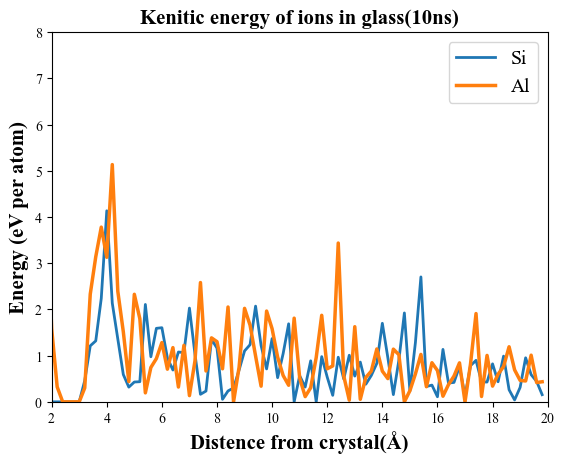

In [380]:
# x1,y1 = ana_ele('O')
x2,y2 = ana_ele('Si')
x3,y3 = ana_ele('Al')

# 分别绘制三条线
# plt.plot(x1, y1, label='O',linewidth=2.0)  # 绘制氧(O)的线
plt.plot(x2, y2, label='Si',linewidth=2.0) # 绘制硅(Si)的线
plt.plot(x3, y3, label='Al',linewidth=2.5) # 绘制铝(Al)的线

# 添加图例和标签
plt.legend(fontsize=14)
plt.ylim(0,8)
plt.xlim(2,20)
plt.xlabel('Distence from crystal(Å)', fontsize=15, fontweight='bold')
plt.ylabel('Energy (eV per atom)', fontsize=15, fontweight='bold')
plt.title('Kenitic energy of ions in glass(10ns)', fontsize=15, fontweight='bold')

# 显示图形
plt.show() 

In [370]:
label_atoms_list[0]

[<__main__.Atom at 0x20f12b37620>, 100, 16.886626947112948]

In [371]:
filter_list_0[0]

NameError: name 'filter_list_0' is not defined

In [ ]:
x,y = ana_ele('O')
plt.plot(x,y)


[<__main__.Atom object at 0x000002020C181790>, 100, 43.2743059944611]


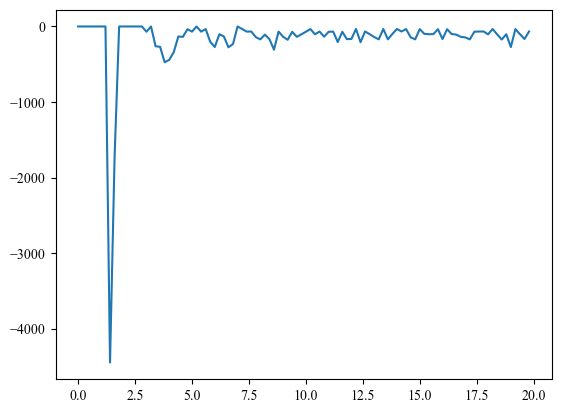

In [198]:
###
x,y = ana_ele('Si')
plt.plot(x,y)

[<__main__.Atom object at 0x000002020C0DED80>, 100, 20.24828276400002]


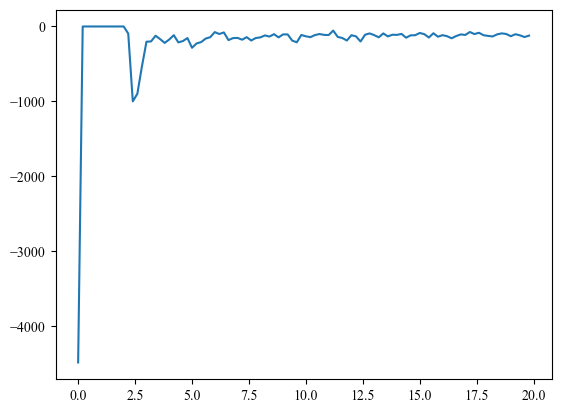

In [200]:
x,y = ana_ele('O')
plt.plot(x,y)


In [222]:
# 设置全局字体为Times New Roman
plt.rcParams['font.family'] = 'Times New Roman'

In [663]:
x1,y1 = ana_ele('O')
x2,y2 = ana_ele('Si')
x3,y3 = ana_ele('Al')

# 分别绘制三条线
plt.plot(x1, y1, label='O',linewidth=2.0)  # 绘制氧(O)的线
plt.plot(x2, y2, label='Si',linewidth=2.0) # 绘制硅(Si)的线
plt.plot(x3, y3, label='Al',linewidth=2.5) # 绘制铝(Al)的线

# 添加图例和标签
plt.legend(fontsize=14)
plt.ylim(-500,50)
plt.xlim(2,20)
plt.xlabel('Distence from crystal(Å)', fontsize=15, fontweight='bold')
plt.ylabel('Energy (eV per atom)', fontsize=15, fontweight='bold')
plt.title('Total energy of ions in glass', fontsize=15, fontweight='bold')

# 显示图形
plt.show()

[<__main__.Atom object at 0x0000020260675970>, 0.12092955150005726, 0.07424115219739173]


IndexError: list index out of range

In [208]:
import math
# id0, type0, q, x, y, z, vx, vy, vz, fx, fy, fz, c_ke_atom, c_pe_atom, v_e_total
def ana_number(ana_atom_list, delta,max_range):
    count_num = math.ceil(max_range/delta)
    data_range = np.arange(0,max_range,delta)
    data_list = np.zeros_like(data_range)
    count_list = np.zeros_like(data_list)
    for i_item in ana_atom_list:
        i_atom,i_q4,i_dis = i_item
        if i_dis<max_range:
            index = math.floor(i_dis/delta)
            # data_list[index]+= np.linalg.norm([i_atom.fx, i_atom.fy, i_atom.fz])
            count_list[index]+=1
    return [data_range,count_list]
def ana_ele_number(ele_type):
    si_list = []
    for i in label_atoms_list:
        if i[0].type == ele_type:
            si_list.append(i)
    print(si_list[0])
    res_si = ana_number(si_list,0.2,20)
    return res_si[0],res_si[1]

[<__main__.Atom object at 0x000002020C0DED80>, 100, 20.24828276400002]


Text(0.5, 1.0, 'Number atoms')

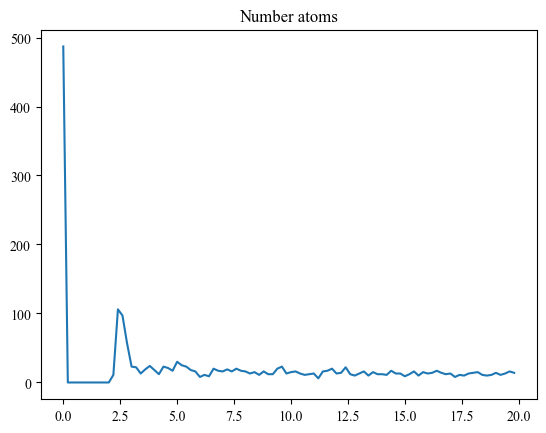

In [148]:
x,y = ana_ele_number('O')
plt.plot(x,y)
plt.title('Number atoms')

In [219]:
# 原子数计算

[<__main__.Atom object at 0x000002020C0DED80>, 100, 20.24828276400002]
[<__main__.Atom object at 0x000002020C181790>, 100, 43.2743059944611]
[<__main__.Atom object at 0x000002020C0DD070>, 100, 20.67698936964712]


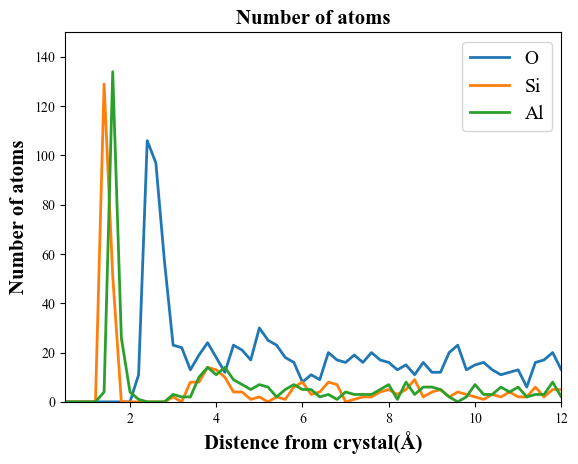

In [221]:
x1,y1 = ana_ele_number('O')
x2,y2 = ana_ele_number('Si')
x3,y3 = ana_ele_number('Al')

# 分别绘制三条线
plt.plot(x1, y1, label='O',linewidth=2.0)  # 绘制氧(O)的线
plt.plot(x2, y2, label='Si',linewidth=2.0) # 绘制硅(Si)的线
plt.plot(x3, y3, label='Al',linewidth=2.0) # 绘制铝(Al)的线

# 添加图例和标签
plt.legend(fontsize=14)
plt.ylim(0,150)
plt.xlim(0.5,12)
plt.xlabel('Distence from crystal(Å)', fontsize=15, fontweight='bold')
plt.ylabel('Number of atoms', fontsize=15, fontweight='bold')
plt.title('Number of atoms', fontsize=15, fontweight='bold')

# 显示图形
plt.show()

# 然后计算 MSD

(5226, 3)
Mean_q4:0.14863865403037366


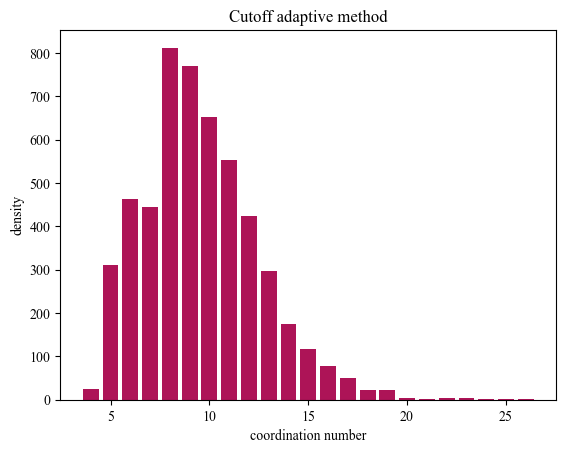

In [382]:
origin_ana_atom_list_0, origin_q4_q6_list_0,box_len_0 = cal_bop(frames,2)

(5226, 3)
Mean_q4:0.14960715902236185


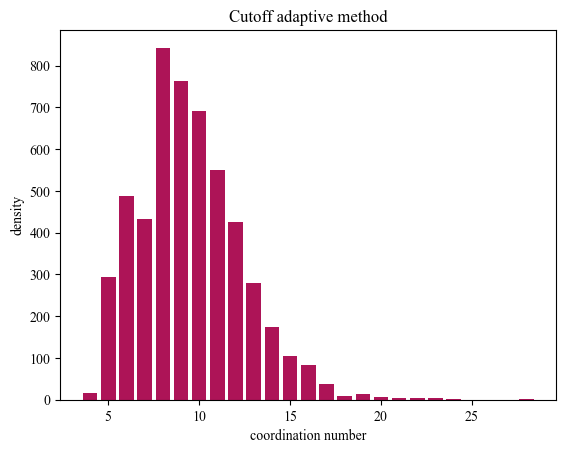

In [383]:
# 得到元素BOP

origin_ana_atom_list_1, origin_q4_q6_list_1,box_len_1 = cal_bop(frames,100)

In [384]:
# 只要 O
draw_element = ['O']
q4_q6_list_0 = origin_q4_q6_list_0.copy()
ana_atom_list_0 = origin_ana_atom_list_0.copy()
results_xyz_q4_q6_0 = select_ele(origin_ana_atom_list_0,draw_element,q4_q6_list_0)
# 
q4_q6_list_1 = origin_q4_q6_list_1.copy()
ana_atom_list_1 = origin_ana_atom_list_1.copy()
results_xyz_q4_q6_1 = select_ele(origin_ana_atom_list_1,draw_element,q4_q6_list_1)
######
# 近邻算法优化BOP
filter_list_0 = filter_bop(results_xyz_q4_q6_0)
filter_list_1 = filter_bop(results_xyz_q4_q6_1)

[<__main__.Atom object at 0x0000020F7A374E30>, 0.12092955150005726, 0.07424115219739173]
[<__main__.Atom object at 0x0000020F12B37620>, 0.14739676717881972, 0.09400733059064009]


In [385]:
filter_list_0[0]

[<__main__.Atom at 0x20f7a374e30>, 0.12092955150005726, 0.07424115219739173]

In [389]:
count = 0
test_list = filter_list_0
for i in test_list:
    if i[1]>0.18:
        count+=1
print(count)
count = 0
test_list = filter_list_1
for i in test_list:
    if i[1]>0.18:
        count+=1
print(count)

476
508


476
See Origin Figure
Mean q4:  0.1348    Percentage of Q4 > 0.18: 13.66%


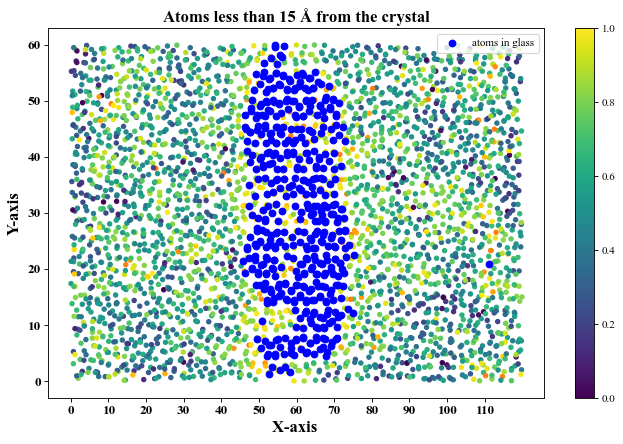

In [401]:
test_temp = filter_list_0
# 先取出所有晶体原子
cry_list = [[],[]]
for i_item in test_temp:
    i_atom,i_q4,i_q6 = i_item
    if i_q4>0.18:
        cry_list[0].append(i_atom.x)
        cry_list[1].append(i_atom.y)
print(len(cry_list[0]))
temp_diff_dis_atom = cry_list
draw_q4(test_temp,0.18,temp_diff_dis_atom)

508
See Origin Figure
Mean q4:  0.1358    Percentage of Q4 > 0.18: 14.58%


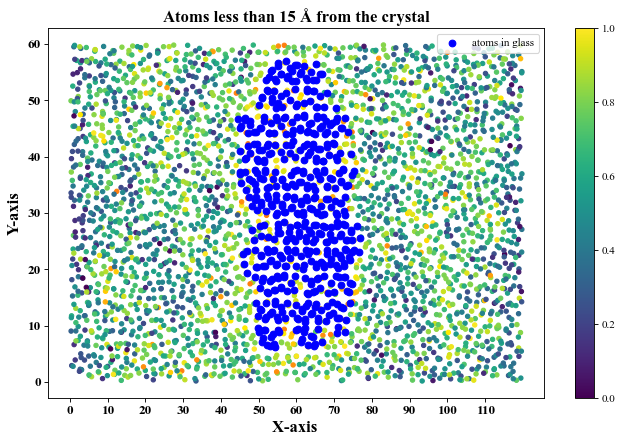

In [399]:
test_temp = filter_list_1
# 先取出所有晶体原子
cry_list = [[],[]]
for i_item in test_temp:
    i_atom,i_q4,i_q6 = i_item
    if i_q4>0.18:
        cry_list[0].append(i_atom.x)
        cry_list[1].append(i_atom.y)
print(len(cry_list[0]))
temp_diff_dis_atom = cry_list
draw_q4(test_temp,0.18,temp_diff_dis_atom)

In [ ]:
# 写入lmp文件

# 绘制 MSD 的函数 

In [635]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.font_manager import FontProperties

def draw(start_xyz,end_xyz,boxsize,list_q4,list_q4_1):

    # 设置全局字体属性
    plt.rcParams['font.weight'] = 'bold'
    plt.rcParams['font.family'] = 'Times New Roman'
    plt.rcParams['font.size'] = 12

    # 设置图像大小
    fig = plt.figure(figsize=(10, 6))

    # 两帧原子的xyz数据，每一帧包含原子的位置信息
    frame1 = np.array(start_xyz)
    frame2 = np.array(end_xyz)

    # 盒子尺寸，假设为 [box_x, box_y, box_z]
    #box_size = [10.0, 10.0, 10.0]

    # 计算位移向量
    displacements = frame2[:, :2] - frame1[:, :2]
    box_size = boxsize
    # 考虑周期性边界条件，根据盒子尺寸修正位移
    for i in range(len(displacements)):
        for dim in range(2):  # 仅考虑 xy 平面
            if displacements[i, dim] > box_size[dim] / 2:
                displacements[i, dim] -= box_size[dim]
            elif displacements[i, dim] < -box_size[dim] / 2:
                displacements[i, dim] += box_size[dim]

    # 计算位移大小
    displacement_magnitude = np.linalg.norm(displacements, axis=1)

    # 计算位移方向
    displacement_direction = displacements / displacement_magnitude[:, np.newaxis]

    # 设置箭头的长度的倍数
    arrow_scale = 2  # 可以根据需要调整箭头的长度

    # 设置颜色映射范围，根据位移大小来映射颜色
    norm = Normalize(vmin=min(displacement_magnitude), vmax=max(displacement_magnitude))

    # 绘制位移图，将位移大小与箭头长度相乘
    plt.quiver(frame1[:, 0], frame1[:, 1], arrow_scale * displacement_direction[:, 0], arrow_scale * displacement_direction[:, 1], 
               arrow_scale * displacement_magnitude, cmap='viridis', angles='xy', scale_units='xy', scale=1, norm=norm)

    # 
    # 设置标题和轴标签的字体和字体大小，以及使用Times New Roman字体
    label_font = FontProperties(family='Times New Roman', style='normal', size=18, weight='bold')


    # 设置图形范围，根据盒子尺寸
    #plt.xlim(0, box_size[0])
    #plt.ylim(0, box_size[1])
    plt.xlabel('X (Å)',fontproperties=label_font)
    plt.ylabel('Y (Å)',fontproperties=label_font)
    # 添加颜色条
    # plt.scatter(list_q4[0],list_q4[1],color='blue',s=30,label='5 ns')
    #plt.scatter(list_q4[0],list_q4[1],color='orange',s=15,label='crystal-like O at 10 ns')
    # title = 'The displacement of '+ ana_element+ ' : '+str(start_frame_num) +' - '+ str(end_frame_num)##+' frame (100ns/1000frames) ' #(60ns/1000frames)
    title = 'MSD of O from 0 ns to 10 ns.'
    plt.title(title, fontproperties=label_font)
    plt.legend()

    # 设置颜色条字体大小、粗细和字体族
    cbar = plt.colorbar(label='Displacement Magnitude')
    cbar.ax.tick_params(labelsize=12, width=2)  # 设置字体大小和粗细
    cbar.ax.yaxis.label.set_font_properties(FontProperties(family='Times New Roman', style='normal', size=12, weight='bold'))

    

    # 显示图形
    plt.show()


In [637]:
start_xyz = []
start_q4 = [[],[]]
###
end_xyz = []
end_q4 = [[],[]]
for i_item in range(len(filter_list_1)):
    i_atom,i_q4 = filter_list_0[i_item][0], filter_list_0[i_item][1]
    j_atom,j_q4 = filter_list_1[i_item][0], filter_list_1[i_item][1]
    i_xyz = [i_atom.x,i_atom.y,i_atom.z]
    j_xyz = [j_atom.x,j_atom.y,j_atom.z]
    start_xyz.append(i_xyz)
    if i_q4>0.18:
        start_q4[0].append(i_atom.x)
        start_q4[1].append(i_atom.y)
    if j_q4>0.18:
        end_q4[0].append(j_atom.x)
        end_q4[1].append(j_atom.y)
    end_xyz.append(j_xyz)

In [639]:
len(end_q4[0])

514

C:\Users\81004\AppData\Local\Temp\ipykernel_8020\3325494677.py:66: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


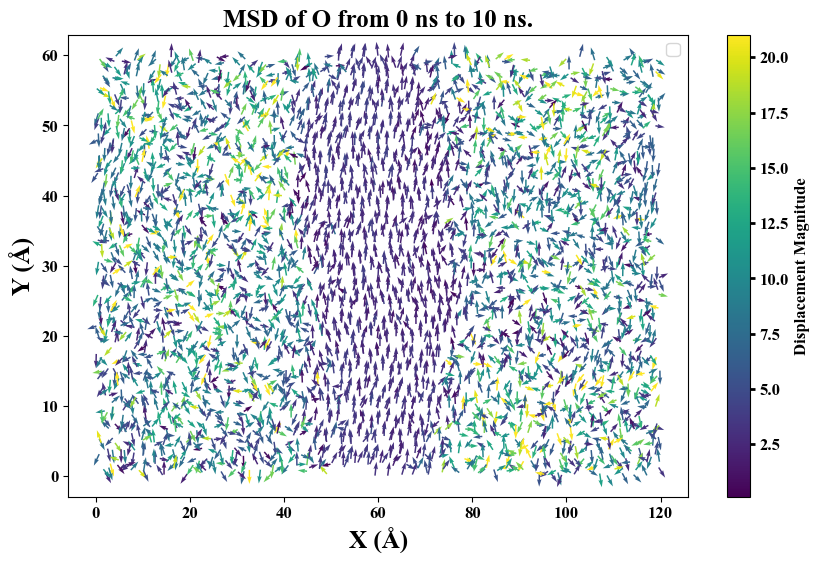

In [641]:
draw(start_xyz,end_xyz,box_len,start_q4,end_q4)

In [228]:
450/600 * 30/0

ZeroDivisionError: float division by zero

# 输出文件

In [6]:
head = 'ITEM: TIMESTEP\n{}\nITEM: NUMBER OF ATOMS\n{}\nITEM: BOX BOUNDS xy xz \
pp pp pp\n0 {}\n0 {} \n0 {}\nITEM: ATOMS id x y z vx vy vz '.format(22,10,22,22,22)
print(head)
row = '{} {} {} {} {} 0 0'.format(0,1, 1,2,1,0.5)
print(row)

ITEM: TIMESTEP
22
ITEM: NUMBER OF ATOMS
10
ITEM: BOX BOUNDS xy xz pp pp pp
0 22
0 22 
0 22
ITEM: ATOMS id x y z vx vy vz 
0 1 1 2 1 0 0


In [7]:
def write_xyz_q4(save_path, result_xyz_q4_q6,i_frame,atom_num):
    # 打开文件以追加内容
    box_x,box_y,box_z = 84.713001, 55.321148, 11.50816
    head = head = 'ITEM: TIMESTEP\n{}\nITEM: NUMBER OF ATOMS\n{}\nITEM: BOX BOUNDS xy xz \
pp pp pp\n0 {}\n0 {} \n0 {}\nITEM: ATOMS id x y z vx vy vz \n'.format(i_frame,atom_num,box_x,box_y,box_z)
    if i_frame==0:
        w_type = 'w'
    else:
        w_type = 'a'
    with open(save_path, w_type) as file:
        # 追加内容
        file.write(head)
        for i in range(len(result_xyz_q4_q6)):
            x,y,z,vx = result_xyz_q4_q6[i][0],result_xyz_q4_q6[i][1],result_xyz_q4_q6[i][2],result_xyz_q4_q6[i][3]
            row = '{} {} {} {} {} 0 0\n'.format(i,x,y,z,vx*100)
            file.write(row)

# 开始多帧计算分析

In [8]:
for i_frame in range(start_frame,end_frame,step_frame):
    data_list = []
    for i in frames[i_frame]['atoms']:
        data_list.append([i['element'],i['x'],i['y'],i['z']])
    result_xyz_q4_q6 = cal_bop(data_list,ana_element,draw_element)
    # 得到结果了 然后把结果存下来
    write_xyz_q4(save_path,result_xyz_q4_q6,i_frame,2292)

D:\python_install\lib\site-packages\pyscal3\atoms.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  dict.__setitem__(self, key, np.array(val))
